# LEGO Bricks
Pour notre projet d'informatique nous avons eu l'instruction de lier Minecraft au monde réel à l'aide d'une Raspberry Pi et d'OpenCV. Puis nous avons eu l'idée: photographier des structures de LEGO et les construires automatiquement dans Minecraft. 

Pour faire ceci nous utilisons: une caméra V2, une structure que nous avons construit qui permet de placer la caméra au dessus d'un espace amenagé pour la construction d'une structure en LEGO. De plus, notre Raspberry Pi est connecté à un bouton qui sert à envoyer un signal à notre programme qui sait alors qu'il doit photographier la structure de LEGO et construire un étage de la structure dans Mineraft_Pi ou alors le programme est informé qu'il doit réinitialiser la construction.

![Struc1](images/structure1.jpeg)
![Struc2](images/structure2.jpeg)

Nous avons programmé un logiciel en Python pour prendre des photos et les analyser à l'aide du module cv2, un module python d'OpenCV.

Le programme marche ainsi: une fois lancé, le programme continue à tourner sur la machine pour que le programme puisse évaluer l'état du bouton à chaque instant.


## Coeur du fonctionnement

L'analyse d'image que l'on fait est assez primaire: le programme observe certains points qu'il définit, un par emplacement de LEGO, et si les couleurs différent trop, il déduit que le bloc a changé. Voici par exemple les points que le programme étudie à chaque pression du bouton (de plus certains points permettent différentes autres options)  :

![Point](images/avec_points.jpg)

Les différents points sont :
- noir : Les points qui vont servir à créer les blocs un par un dans le jeu.
- vert : Celui qui va créer le jardin
- bleu : Celui qui va générer la fontaine
- rouge : Celui qui va générer la maison
- jaune : Le point de référence, il ne doit pas être modifié entre chaque image et sert donc de référence pour connaitre la différence de luminosité globale entre chaque prise de vue.

Pour vérifier chaque point, nous utilisons la méthode checkDif():

In [1]:
def checkDif(img1, img2, x, y, dif2, tolerence=70):
        pos1 = int(img1[x, y])
        pos2 = int(img2[x, y])
        dif = pos1 - pos2 - dif2
        if dif < 0:
            dif = -dif
        return dif >= tolerence

La méthode va regarder si au point que l'on veut analyser, la différence de couleur entre l'image 1 et l'image 2 est plus grande que la tolerence que l'on a définit.
dif2 est la différence de couleur au point marqué en jaune sur l'image précédente, cette valeur premet, comme dit précédement, d'être moins dépendant de la luminosité.

Petit exemple :


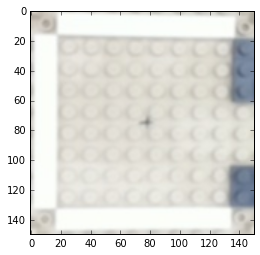

In [2]:
last = cv2.imread("images/base.jpg")
pltShow(last)

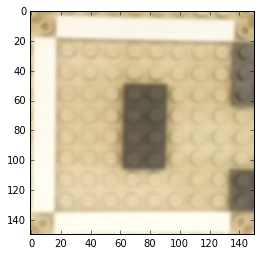

In [3]:
new = cv2.imread("images/new.jpg")
pltShow(new)

Tout d'abord, on crée "l'étalon", avec le point jaune, on regarde combien vaut la différence de couleur entre la permière image et la seconde.

In [21]:
(b1, g1, r1) = last[pointToWatch[0], pointToWatch[1]]
(b2, g2, r2) = new[pointToWatch[0], pointToWatch[1]]

r = r1-r2
g = g1-g2
b = b1-b2

print(r, g, b)

31 44 73


Ensuite, on sépare l'image en chaqu'un de ses channel, pour les étudier séparemment.

In [22]:
(B1, G1, R1) = cv2.split(last)
(B2, G2, R2) = cv2.split(new)

Puis il faut observer pour chaque point défini dans la position, si la différence de couleur dans au moins un des channels dépasse le seuil de tolérence, grâce à la méthode checkDif définie plus tôt.
Si c'est le cas, le programme place un bloc dans le jeu aux coordonnées corréspendantes. Ici, il ne fait que les afficher.

In [23]:
for (mcx, mcy, x, y) in positions:
    if (checkDif(B1, B2, x, y, b) or checkDif(G1, G2, x, y, g) or checkDif(R1, R2, x, y, r)):
            # placeBlock(mcx, mcy), expliqué plus tard
            print("({}; {})".format(mcx, mcy))

(2; 3)
(2; 4)
(3; 3)
(3; 4)
(4; 3)
(4; 4)
(5; 3)
(5; 4)


Le plus intéressant est la manière que l'on a de trouver les positions et les modification nécessaire à l'image pour qu'elle rentre dans ce carré. Voilà ce que voit la caméra :

![brute](images/before.jpg)

Tout cela se passe pendant l'initialisation :


Tout d'abord, l'utilisateur doit entrer les coordonnées des sommets du carré visé. Nous avons créé un notebook jupyter pour faciliter cette opération, son nom est `initialization helper`.
Voilà le carré trouvé avec cette méthode :

In [24]:
upper_left = (227, 146)
upper_right = (450, 142)
down_left = (230, 362)
down_right = (447, 362)

Ce qui donne ceci :
    
![Cadre](images/cadre.jpg)

Nous utilisons ensuite l'algorithme de perspective d'OpenCV pour recréer le carré.
On commence par créer la matrice de perspective :

In [30]:
inCorners = np.float32([[upper_left[0], upper_left[1]], [upper_right[0], upper_right[1]],
                        [down_left[0], down_left[1]], [down_right[0], down_right[1]]])
outCorners = np.float32([[0, 0], [150, 0], [0, 150], [150, 150]])

M = cv2.getPerspectiveTransform(inCorners, outCorners)

Nous pourrons ensuite utiliser la matrice de transformation M pour chaque image que la caméra prend. Voici comment elle est utilisée :

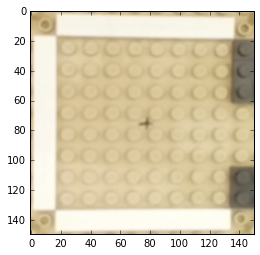

In [33]:
frame = cv2.imread("images/before.jpg")
frame = cv2.warpPerspective(frame, M, (150, 150))
pltShow(frame)

A présent parlons des qui doivent être vérifiés. Nous utilisons la méthode buildPositions, qui va calculer la position des points en fonction de la taille de l'image, de la bordure qu'on lui donne et du nombre de points par ligne que l'on veut.

![Schema](images/schema.png)

La position du point (x; y) avec x et y, des entiers compris entre 0 et n-1, est donné par la fonction :
$$b = \frac{d - l}{2}$$
$$x' = b + \frac{l}{n-1}*x$$
$$y' = b + \frac{l}{n-1}*y$$

In [11]:
def buildPositions(n, bordure, largeurTotale):
    poses = []
    for mcx in range(n):
        for mcy in range(n):
            poses.append((mcx,
                          mcy,
                          int(bordure+(largeurTotale-2*bordure)/(n-1)*mcx),
                          int(bordure+(largeurTotale-2*bordure)/(n-1)*mcy)))
    return poses

positions = buildPositions(8, 25, 150)

Enfin, il faut définir l'emplacement des points suivants :

In [34]:
pointToWatch = (3, 30)
garden = (67, 145)
fountain = (81, 145)
house = (97, 145)

Leur emplacement ne doit théoriquement pas être revu, ceux-ci dépendants du carré final.

In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from picamera.array import PiRGBArray
from picamera import PiCamera

def pltShow(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

## Détéction du bouton
Pour que le bouuton soit détécté correctement, nous utilisons une boucle infinie qui met à jour l'état de celui-ci dans la variable `flag`Celle-ci a trois états possible :
- 0 : Relâché, le bouton n'est pas appuyé
- 1 : Appuyé, le bouton est appuyé
- ' ' : Juste relâché, l'on vient de relâché le bouton. Pour plusieurs raisons qui seront expliquées plus tard, nous executons la fonction au relâchement du bouton, et non à sa pression.

Voici la fonction de mise à jour d'état, elle est appelée à chaque execution de la boucle infinie :

In [1]:
def update_button():
    pressed = not gpio.input(button)
    last_pressed = flag == 1

    if pressed:
        if time_flag == 0:
            flag = 1
            time_flag = time.time()
    elif time.time() - time_flag > antirebond_time:
        if last_pressed:
            flag = ' '
        else:
            flag = 0
            time_flag = 0

Pour ce qui est de l'utilisation de l'état du bouton, voici ce que nous faisons :
```
if flag == ' ':
    if not alreadyReset:
        last_pic = new_pic
        new_pic = frame
        onButtonPressed()
    alreadyReset = False
elif flag == 1:
    if(time_flag != 0 and
            time.time() - time_flag > resetPushTime and
            not alreadyReset):
        reset()
        alreadyReset = True
```
Il faut savoir qu'avec notre bouton, nous pouvons faire deux choses :
- Prendre une photo et ajouter les blocs trouvés
- Réinitialiser la plateforme du jeu en effectuant une longue pression.C'est pour cela que nous executons la fonction `onButtonPressed()` lorsque le bouton est relâché. 

Pour ce qui est du code en lui même, le programme commence par vérfier si le bouton vient d'être relâché, si c'est le cas et que la réinitilasiation n'a pas déjà eu lieu pendant la pression de celui-ci, il execute la fonction onButtonPressed(). Sinon, si le bouton est actuellement appuyé et que son temps de pression est plus grand que celui définie pour réinitialiser la plateforme, si c'est le cas, il la réinitialise et il s'en souvient.

## Intégration à Minecraft
Pour le passage du programme à Minecraft , nous créons la platfrome à l'initialisation et la plaçons de sorte à ce que les coordonnées de celle-ci cohincïdes avec celles contenues dans `positions` Puis, lorsque le bouton est pressé et que le programme détécte des changmeents, il appelle la fonction `placeBlock(x, z)` :

In [3]:
def placeBlock(x, z):
    mc.setBlock(x, height, z, 35, 15)

La fonction est très simple, elle ne fait que placer un bloc aux bonnes coordonnées.

Exemple, avec à gauche l'image prise par la caméra, et à droite, son impacte dans le jeu :
![0](images/0-f.png)
![1](images/1-f.png)
![2](images/2-f.png)
![3](images/3-f.png)

Pour ce qui est des structures préféfinies, nous avons créé trois fonctions, une pour chaque structure. Et elles sont appelées si la fonction `checkDif()` trouve un changement aux points définis.

```
i = 0
for (x, y) in [garden, fountain, house]:
    if (checkDif(B1, B2, x, y, b) or
            checkDif(G1, G2, x, y, g) or
            checkDif(R1, R2, x, y, r)):
        if i == 0:
            build_garden(4, 0, 4)
        elif i == 1:
            build_fountain(6, 0, 6)
        elif i == 2:
            build_house(1, -1, 1)

    i += 1
```

Cette partie du code est placée juste après la partie qui étudie, pour chaque point dans `positions` s'il y a un changment.



## Conclusion

Nous pouvons affirmer que nous avons atteint notre objectif. Nous avons réussi à utiliser une caméra pour transférer des constructions LEGO dans Minecraft. Nous avons dû faire plusieurs compromis, comme le fait de ne pas pouvoir réellement construire un objet en entier pour qu'il soit reproduit dans le jeu, car les ombres créées par les briques gênaient la détection et que l'on ne pouvait pas évaluer la hauteur d'une brique. 
Nous avons aussi découvert l'algorithme de perspective de cv2 assez tard, et nous aurions sûrement fait une détection des coins avec une analyse d'image plutôt que de demander à l'utilisateur de les entrer par lui même. C'est d'ailleurs une amélioration à laqual nous avons pensée. Avec la possibilité de faire des constructions étage par étage, il nous faudrait une meilleure gestion de la lumière pour cela, pour avoir le moins d'ombres.

Pour finir, nous sommes fiers d'avoir fait ce projet et de le présenter à notre examen d'option complémentaire informatique, nous avons aimé travailler dessus, arriver à un problème, le résoudre, ou le contourner comme on peut. Nous souhaitons remercier M. Holzer pour nous avoir facilité l'accès à OpenCV, malgré un légère mécontentement des instructions à cause du caractère enfantin de Minecraft, nous avons trouvé l'expérience enrichissante.
